In [1]:
!wget https://github.com/d-uni/LPPL_model/archive/refs/heads/main.zip
!unzip main.zip
%cd LPPL_model-main

--2025-12-06 19:39:21--  https://github.com/d-uni/LPPL_model/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/d-uni/LPPL_model/zip/refs/heads/main [following]
--2025-12-06 19:39:21--  https://codeload.github.com/d-uni/LPPL_model/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip.2’

main.zip.2              [ <=>                ] 736.12K  --.-KB/s    in 0.03s   

2025-12-06 19:39:22 (27.0 MB/s) - ‘main.zip.2’ saved [753791]

Archive:  main.zip
9b521ecde95913ab42d507c63218a0cc19e398b6
replace LPPL_model-main/Example_of_usage.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# !git clone https://github.com/d-uni/LPPL_model.git
# %cd LPPL_model

fatal: destination path 'LPPL_model' already exists and is not an empty directory.
/content/LPPL_model-main/LPPL_model


In [23]:
from model_lppls import ModelLPPLS
from rolling_calibrator import RollingLPPLCalibrator
from distribution_calibrators import (
    DistributionLPPLCalibrator_for_different_Windows,
    DistributionLPPLCalibrator_for_different_Dates,
)
from LPPLIndicatorGenerator import LPPLIndicatorGenerator
from visualization import plot_lppls_results, plot_tc_distribution,plot_combined_tc_distributions

# Test model_lppls.py

In [7]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

data = yf.download("000001.SS", start="2007-01-01", end="2008-01-01")
price_series = data["Close"].dropna()

t1 = "2007-03-12"
t2 = "2007-10-10"
fit_window = price_series[t1:t2]


dates = pd.to_datetime(fit_window.index)
t = (dates - dates[0]).days / 365.25  # time in years since start
p = fit_window.values  # price values

initial_guess = [t[-1] + 0.08, 0.5, 9.0]

model = ModelLPPLS(t, p)
model.set_calibration_date(t2)

model.fit(initial_guess)
model.summary()

[*********************100%***********************]  1 of 1 completed


,calibration_date,tc,A,B,C1,C2,m,omega,kappa,sign
0,2007-10-10,0.573951,1.289635e+08,-1.289634e+08,0.025472,0.037758,2.094974e-10,13.597429,1.289634e+08,1


# Test rolling_calibrator.py

In [5]:
# --- Download data ---
SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2009-10-29"
data_rolling_calibrator  = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_rolling_calibrator
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()



rolling_calibrator = RollingLPPLCalibrator(t_series, p_series)

# ------ Acceptance thresholds
rolling_calibrator.set_acceptance_thresholds(
    r2_min=0.95, rmse_max=0.04, kappa_min=0.05, tc_horizon_years=0.5
)

result_rolling_calibrator = rolling_calibrator.run(
    start_roll = 1.0,       # start of rolling period (years)
    end_roll = 4.0,         # end of rolling period (years)
    window_years = 1.0,     # window size
    step_years = 4 / 365.25 # step = 2 days
)

In [6]:
result_rolling_calibrator.head()

,window_start,window_end,window_size,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,0.339493,1.339493,1.0,1.661715,7.430758,-0.235454,-0.026940,-0.018858,0.558460,7.074848,0.954129,0.011930,0.235454,1
1,0.350445,1.350445,1.0,1.486496,7.364182,-0.185464,-0.038600,0.011603,0.578398,5.022790,0.964665,0.010714,0.185464,1
2,0.361396,1.361396,1.0,1.455712,7.357998,-0.181408,-0.039512,0.014155,0.559244,4.606658,0.967094,0.010424,0.181408,1
3,0.372348,1.372348,1.0,1.465433,7.366999,-0.191316,-0.039543,0.009568,0.543102,4.625501,0.968825,0.010246,0.191316,1
4,0.383299,1.383299,1.0,1.501189,7.381285,-0.203992,-0.038050,0.003540,0.543240,4.997805,0.969360,0.010263,0.203992,1


# Test distribution_calibrators.py

In [8]:
target_date_ = pd.Timestamp("2007-06-06")

SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2009-01-01"
data_tc_distribution_over_window = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_tc_distribution_over_window
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()

calibrator = DistributionLPPLCalibrator_for_different_Windows(t_series, p_series)

# --- Acceptance thresholds ---
calibrator.set_acceptance_thresholds(
    r2_min=0.9,
    rmse_max=0.06,
    kappa_min=0.05,
    tc_horizon_years=0.5
)
calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)

target_date = (target_date_ - data.index[0]).days / 365.25 #!!!!!!! <- <- <- <- <- <- CONSIDER TARGET DAY

result_tc_distribution_over_window = calibrator.tc_distribution_over_window(
    target_date=target_date,
    min_window_years=1/12,  # 1 month
    max_window_years=1.0,   # 1 year
    step_window_years=1/365.25, # increment by 1 day
    acceptance_thresholds=True # IF you put False -> you don't take into account the thresholds, presented earlier
)

In [9]:
result_tc_distribution_over_window.head()

,window_years,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,0.669233,1.476120,7.560396,-0.360458,-0.019302,0.010430,0.176857,4.907589,0.912121,0.009710,0.360458,1
1,0.671971,1.475758,7.550886,-0.351352,-0.019593,0.010367,0.183011,4.895056,0.913695,0.009682,0.351352,1
2,0.677447,1.470992,7.467617,-0.273749,-0.023658,0.009184,0.263447,4.729850,0.916391,0.009724,0.273749,1
3,0.680185,1.470992,7.467617,-0.273749,-0.023658,0.009184,0.263447,4.729850,0.916391,0.009724,0.273749,1
4,0.682923,1.470992,7.467617,-0.273749,-0.023658,0.009184,0.263447,4.729850,0.916391,0.009724,0.273749,1


In [10]:
# --- Download data ---
SYMBOL = "^GSPC"
START_DATE, END_DATE = "2006-01-01", "2009-01-01"
data_tc_distribution_over_dates = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)["Close"].dropna()

data = data_tc_distribution_over_dates
t_series = (data.index - data.index[0]).days / 365.25
p_series = data.values.squeeze()

# --- Initialize calibrator ---
calibrator = DistributionLPPLCalibrator_for_different_Dates(t_series, p_series)
calibrator.set_model_params_initial_guess(tc_offset=0.12, m0=0.55, omega0=9.0)
calibrator.set_acceptance_thresholds(r2_min=0.9, rmse_max=0.06, kappa_min=0.05, tc_horizon_years=0.5)

# --- Parameters ---
target_date = (target_date_ - data.index[0]).days / 365.25
window_years = 1.0                 # fixed calibration window
distribution_window_years = 3/12    # look 6 months before target date
step_years = 1 / 365.25            # 5 days between calibrations

# --- Run distribution over calibration dates ---
result_tc_distribution_over_dates = calibrator.tc_distribution_over_dates(
    target_date=target_date,
    window_years=window_years,
    distribution_window_years=distribution_window_years,
    step_years=step_years,
    acceptance_thresholds=True
)

In [11]:
result_tc_distribution_over_dates.head()

,calibration_date,tc,A,B,C1,C2,m,omega,r2,rmse,kappa,sign
0,1.201061,1.057210,7.262422,-0.148777,0.083924,0.047477,0.992124,3.085423,0.933499,0.012589,0.148777,1
1,1.203799,1.057210,7.262422,-0.148777,0.083924,0.047477,0.992124,3.085423,0.933499,0.012589,0.148777,1
2,1.387235,1.495357,7.379476,-0.202668,-0.038319,0.004178,0.542156,4.925754,0.969454,0.010259,0.202668,1
3,1.389973,1.492625,7.379668,-0.203445,-0.038447,0.003701,0.539536,4.867482,0.969958,0.010200,0.203445,1
4,1.392710,1.484537,7.378229,-0.203122,-0.038878,0.003559,0.536088,4.738562,0.970485,0.010103,0.203122,1


# Test visualization.py

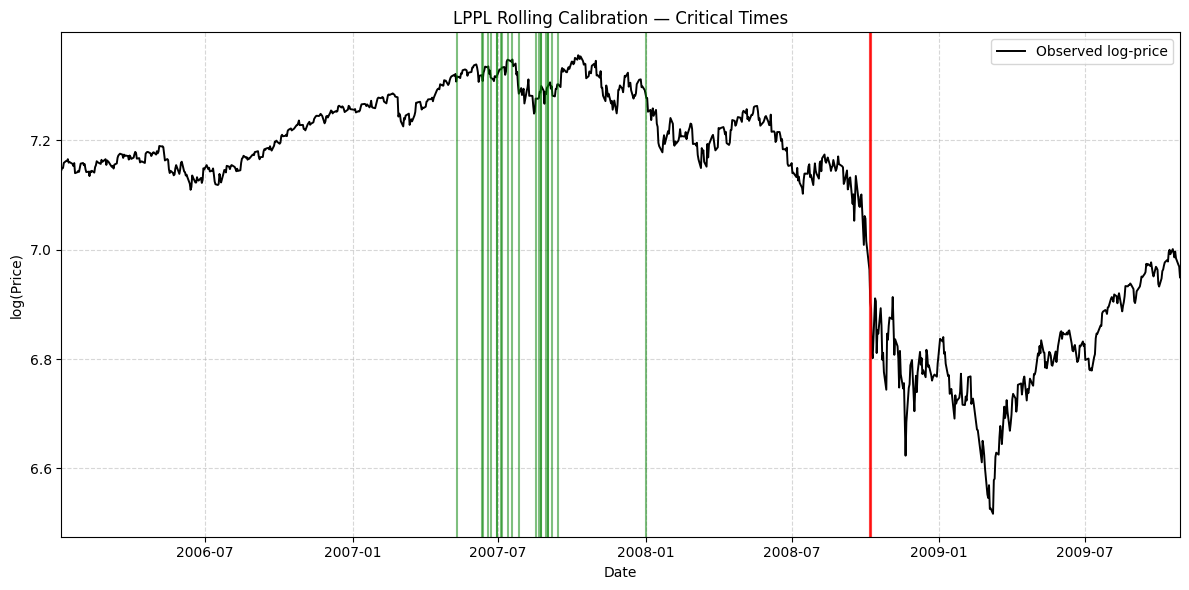

In [12]:
plot_lppls_results(data_rolling_calibrator, result_rolling_calibrator)

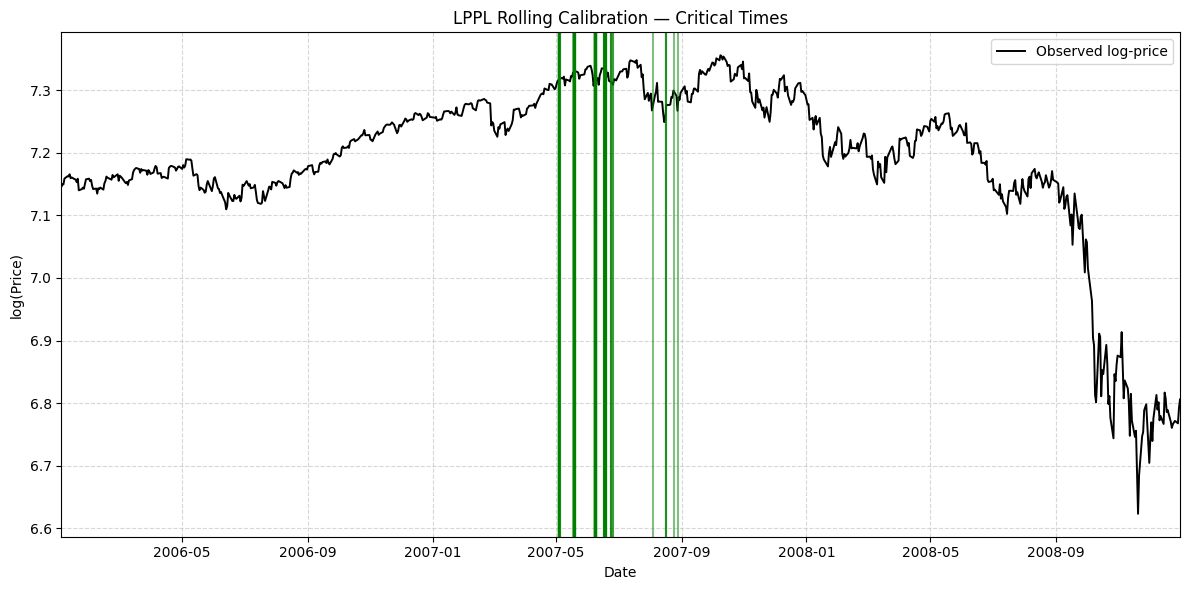

In [13]:
plot_lppls_results(data_tc_distribution_over_window, result_tc_distribution_over_window)

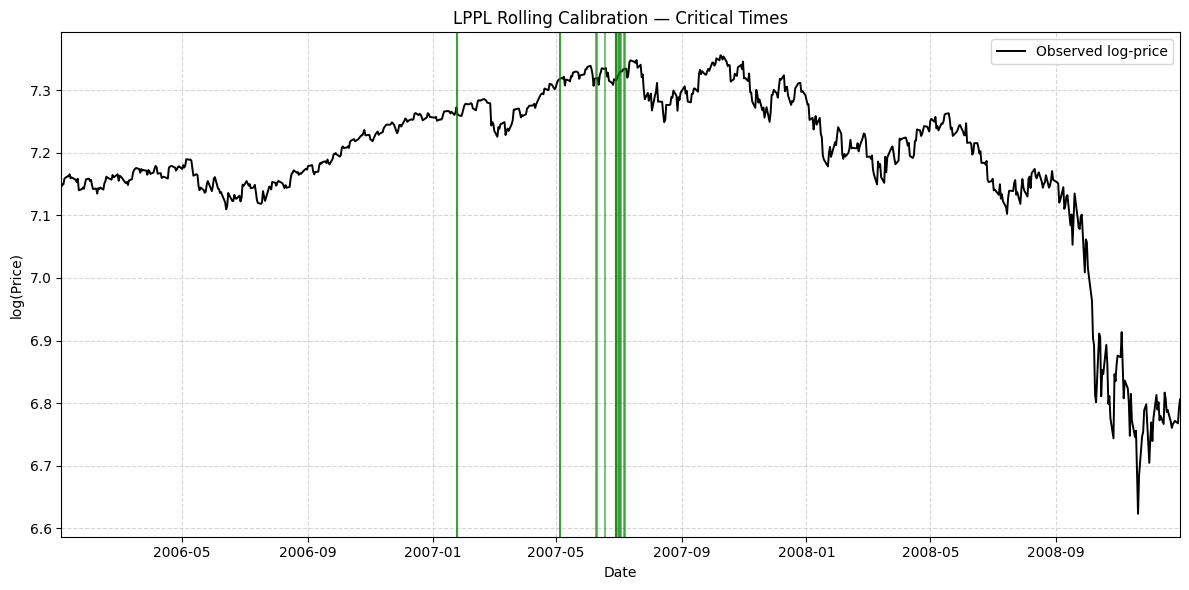

In [14]:
plot_lppls_results(data_tc_distribution_over_dates, result_tc_distribution_over_dates)

In [15]:
tc_predicted_from_start_dates = result_tc_distribution_over_dates["tc"]-(target_date_ - data_tc_distribution_over_dates.index[0]).days / 365.25

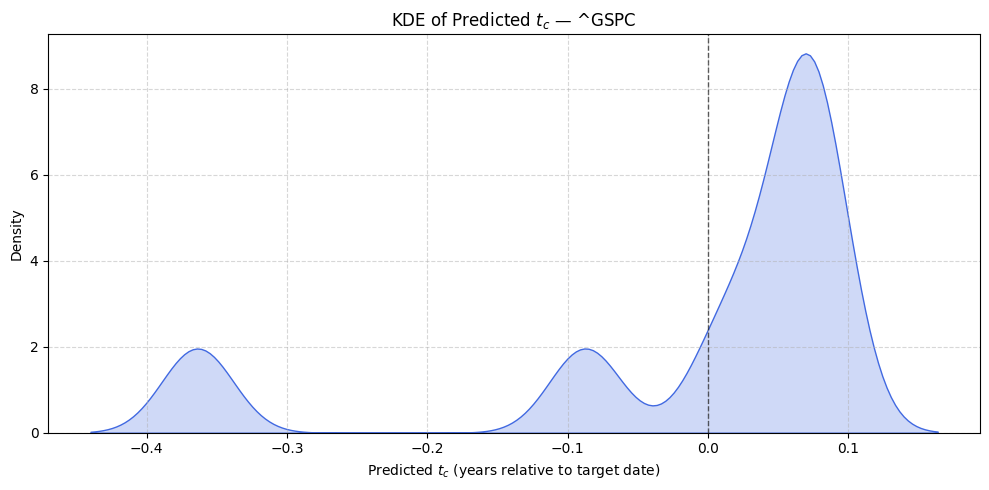

In [16]:
plot_tc_distribution(tc_predicted_from_start_dates, symbol=SYMBOL)

In [17]:
tc_predicted_from_start_window = result_tc_distribution_over_window["tc"]-(target_date_ - data_tc_distribution_over_window.index[0]).days / 365.25

In [18]:
result_tc_distribution_over_window["tc"]

,tc
0,1.476120
1,1.475758
2,1.470992
3,1.470992
4,1.470992
...,...
114,1.452643
115,1.429532
116,1.429753
117,1.454658


In [19]:
data_tc_distribution_over_window.index[0]

Timestamp('2006-01-03 00:00:00')

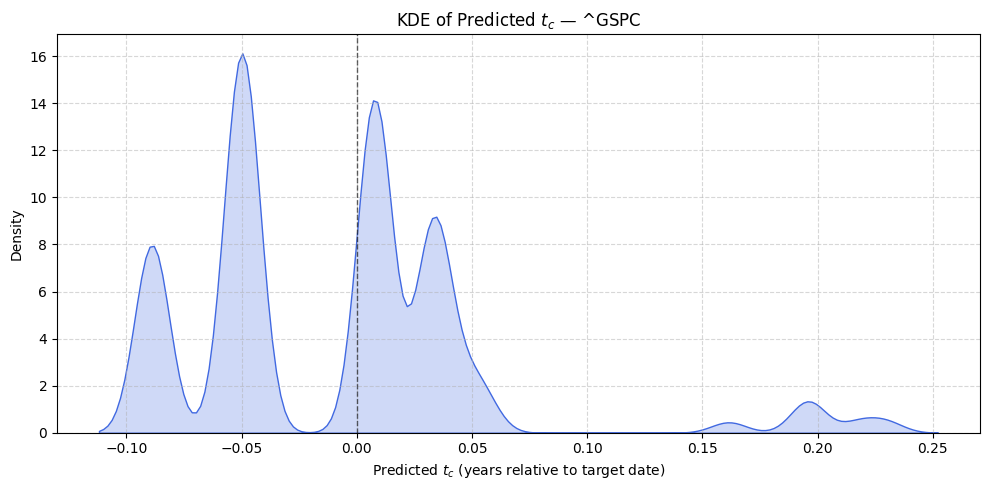

In [20]:
plot_tc_distribution(tc_predicted_from_start_window, symbol=SYMBOL)

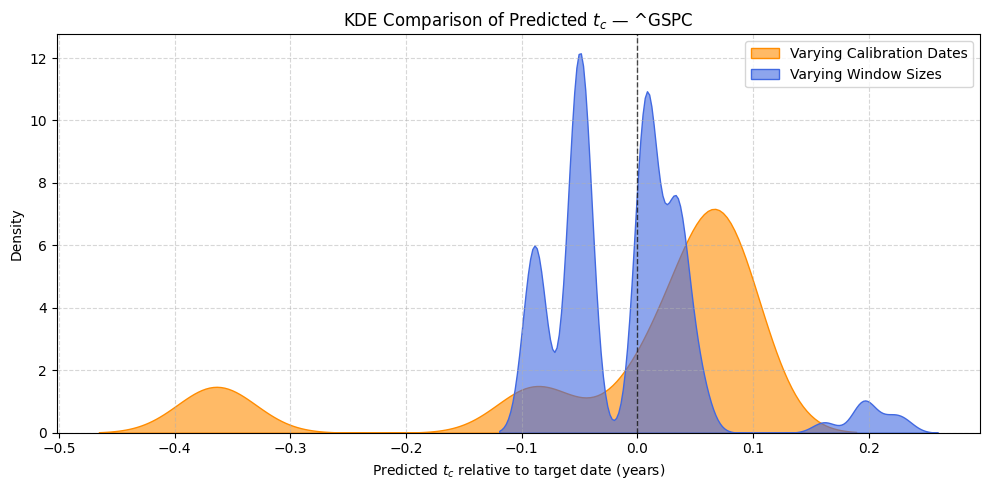

In [21]:
plot_combined_tc_distributions(tc_predicted_from_start_dates, tc_predicted_from_start_window, symbol=SYMBOL)

# Test of LPPLIndicatorGenerator.py

In [24]:
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1. Download data (example: S&P 500)
SYMBOL = "^GSPC"
data = yf.download(SYMBOL, start="2006-01-01", end="2009-01-01",
                   progress=False, auto_adjust=True)["Close"].dropna()

# 2. Build indicator generator
gen = LPPLIndicatorGenerator(
    price_series=data,
    qualified_fit_r2_min=0.9,
    qualified_fit_rmse_max=0.06,
    qualified_fit_kappa_min=0.05,
    qualified_fit_tc_horizon_years=0.5,
)

# 3. Compute indicator table
indicators = gen.build_indicator_table(
    years_for_calibration=1.5,
    diff_windows_indicator_min_window_years=1/12,
    diff_windows_indicator_max_window_years=1.0,
    diff_windows_indicator_step_window_years=20/365.25,      # coarser for speed
    diff_dates_indicator_neighborhood_years=1/12,
    diff_dates_indicator_step_years_dates=5/365.25,
    crash_HORIZON_years_for_indicator=0.25,
)

# 4. Save to CSV
df = gen.to_csv("lppl_indicators_sp500.csv")
df.head()

Computing LPPL indicators: 100%|██████████| 755/755 [04:55<00:00,  2.56it/s]


,n_fits_diff_windows_percentage (%),n_fits_diff_dates_percentage (%),Proba_crash_in_HORIZON_time_diff_windows,Proba_crash_in_HORIZON_time_diff_dates,trustworthiness_percentage,bubble_sign
date,,,,,,
2007-07-05,27,100,0.961110,0.648927,0.226492,1.0
2007-07-06,27,100,0.956255,0.637784,0.227973,1.0
2007-07-09,27,100,0.896182,0.644691,0.265415,1.0
2007-07-10,27,100,0.808254,0.795765,0.440532,1.0
2007-07-11,22,100,0.982747,0.744076,0.271950,1.0
